<div align="center">
    <font color="0F5298" size="7">
        Deep Learning <br>
    </font>
    <font color="2565AE" size="5">
        CE Department <br>
        Spring 2024 - Prof. Soleymani Baghshah <br>
    </font>
    <font color="3C99D" size="5">
        HW2 Practical <br>
    </font>
    <font color="696880" size="5">
        30 Points
    </font>
</div>


In [ ]:
FULLNAME = 'Mobina Poulaei'
STD_ID = '403206962'

In this notebook, we aim to perform **classification** on images from the **CIFAR10** dataset using CNN networks. First, we load the dataset and apply the necessary transformations for normalization and augmentation. After that, we visualize some samples. Once we familiarize ourselves with the dataset, we proceed to design the desired convolutional network, which is explained in the relevant section. After designing the model, we move on to training and evaluating it. At the end of the first section, we analyze the feature space from different perspectives. First, using the KNN method, we examine the closest samples to each other in the feature space. Then, we cluster the data and finally visualize the outputs of the intermediate layers of the model.

In the second part of the notebook, we perform a simple transfer learning task on the trained model from the first section but using a new dataset, **CIFAR100**. To do this, we modify the final layer of the network and retrain it. Further details are provided in the relevant section. Finally, we evaluate the model’s accuracy on the new task and analyze the extracted features and how well the model generalizes. After designing and training the model, we will further analyze the extracted feature space. Finally, we will evaluate the generalization ability of the model and its extracted features on a new dataset,

# CIFAR10 Classification

## Import Libraries

Import needed libraries

In [ ]:
import math
import torch
import random
import torchvision
import numpy as np
from torch import nn
from time import time
import seaborn as sns
from tqdm import tqdm
from random import sample
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import logging
logging.getLogger("matplotlib.image").setLevel(logging.ERROR)

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# TODO: Data Transforms

mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                ])

test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),
                                ])


# TODO: Load Train Data
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# TODO: Split Train and Validation Data
train_dataset, val_dataset = random_split(dataset, [42500, 7500], generator=torch.Generator().manual_seed(1))

# TODO: Load Test Data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# TODO: Define Data Loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)

100%|██████████| 170M/170M [00:04<00:00, 38.8MB/s]


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

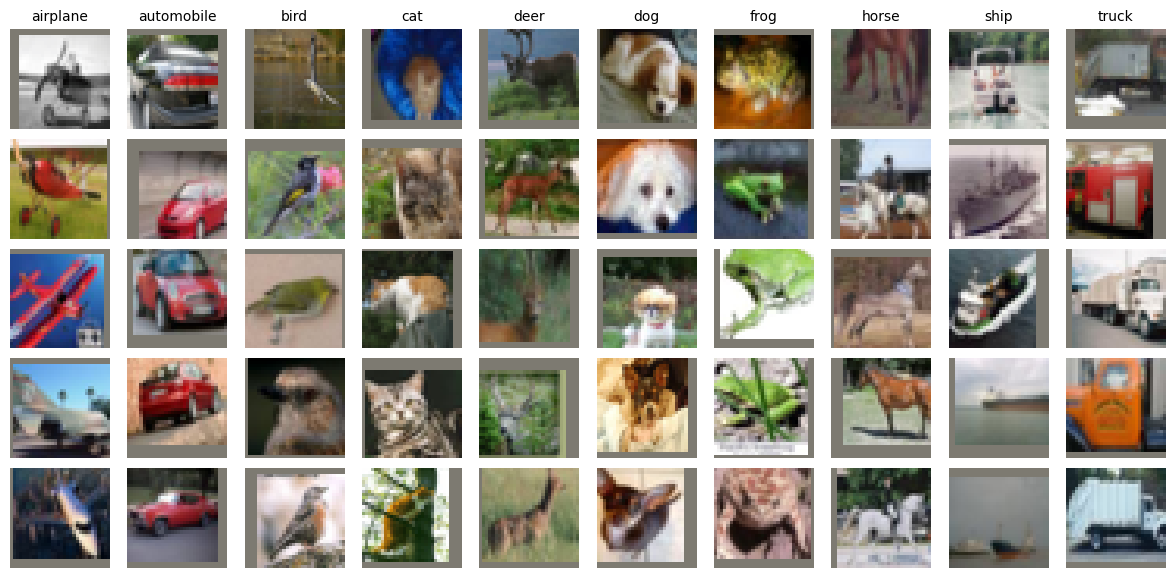

In [ ]:
# TODO: Find 5 Images from Each Class

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
images, labels = next(iter(data_loader))

num_images_per_class = 5
selected_images = {cls: [] for cls in range(10)}

for cls in range(10):
    class_indices = np.where(labels.numpy() == cls)[0]
    selected_indices = sample(list(class_indices), num_images_per_class)
    selected_images[cls] = [images[i] for i in selected_indices]

# Plot Images
fig, axes = plt.subplots(nrows=num_images_per_class, ncols=10, figsize=(15, 7))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for col, (cls, imgs) in enumerate(selected_images.items()):
    for row, img in enumerate(imgs):
        ax = axes[row, col]
        img = img*std + mean
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow(img)
        if row == 0:
          ax.set_title(dataset.classes[cls], fontsize=10)
        ax.axis("off")

plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [ ]:
# TODO: Implement Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

        layers = []
        if stride != 1 or in_channels != out_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            self.identity = nn.Sequential(*layers)

        else:
            self.identity = nn.Sequential()

    def forward(self, x):

        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)

        # Skip connection
        output += self.identity(x)
        output = self.relu(output)

        return output

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Define 4 rsidual blocks
        self.res1 = nn.Sequential(ResidualBlock(64, 64, stride=1),
                                  ResidualBlock(64, 64, stride=1))

        self.res2 = nn.Sequential(ResidualBlock(64, 128, stride=2),
                                  ResidualBlock(128, 128, stride=1))

        self.res3 = nn.Sequential(ResidualBlock(128, 256, stride=2),
                                  ResidualBlock(256, 256, stride=1))

        self.res4 = nn.Sequential(ResidualBlock(256, 512, stride=2),
                                  ResidualBlock(512, 512, stride=1))

        self.avgpool = nn.AvgPool2d((4, 4))
        self.fc = nn.Linear(512, num_classes)

    def feature_space(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Residual layers
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

    def forward(self, x):
        x = self.feature_space(x)
        x = self.fc(x)

        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
# TODO: Define Model
model = ResNet18()
model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
# TODO: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000125)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
# TODO: Implement Training Loop
def train_loop(model, data_loader, criterion, optimizer):

    model.train()
    running_loss = 0
    correct = 0

    train_loader_tqdm = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

        train_loader_tqdm.set_postfix({
            "Loss": f"{loss.item():.3e}",
            "Acc": f"{100 * correct / len(data_loader.dataset):.2f}%"
        })

    loop_loss = running_loss / len(data_loader.dataset)
    loop_acc = 100 * correct / len(data_loader.dataset)

    return loop_loss, loop_acc

In [ ]:
# TODO: Implement Validation Loop
def val_loop(model, data_loader, criterion, scheduler):

    model.eval()
    scheduler.step()
    running_loss = 0
    correct = 0

    val_loader_tqdm = tqdm(data_loader, desc="Validating", leave=True)
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          running_loss += loss.item() * inputs.size(0)
          _, preds = torch.max(outputs, 1)
          correct += (preds == labels).sum().item()

          val_loader_tqdm.set_postfix({
              "Loss": f"{loss.item():.3e}",
              "Acc": f"{100 * correct / len(data_loader.dataset):.2f}%"
          })

    loop_loss = running_loss / len(data_loader.dataset)
    loop_acc = 100 * correct / len(data_loader.dataset)

    return loop_loss, loop_acc

In [ ]:
# Implement Test Loop
def test_loop(model, data_loader):

    model.eval()
    correct = 0

    test_loader_tqdm = tqdm(data_loader, desc="Testing", leave=True)
    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)

          _, preds = torch.max(outputs, 1)
          correct += (preds == labels).sum().item()

          test_loader_tqdm.set_postfix({
              "Acc": f"{100 * correct / len(data_loader.dataset):.2f}%"
          })

    loop_acc = 100 * correct / len(data_loader.dataset)

    return loop_acc

In [ ]:
# TODO: Train The Model
num_epochs = 60
best_val_loss = float('inf')
model_path = '/content/resnet18.pt'

acc_dic, loss_dic = {}, {}
loss_dic['train'], loss_dic['val'] = [], []
acc_dic['train'], acc_dic['val'] = [], []

for epoch in range(num_epochs):
    start_time = time()
    train_loss, train_acc= train_loop(model, train_loader, criterion, optimizer)
    val_loss, val_acc = val_loop(model, val_loader, criterion, scheduler)
    end_time = time()

    loss_dic['train'].append(train_loss)
    loss_dic['val'].append(val_loss)
    acc_dic['train'].append(train_acc)
    acc_dic['val'].append(val_acc)

    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1:3d} finished in {epoch_time:.2f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)

Validating: 100%|██████████| 59/59 [00:04<00:00, 13.54it/s, Loss=1.628e+00, Acc=50.72%]


Epoch   1 finished in 39.92s


Validating: 100%|██████████| 59/59 [00:04<00:00, 13.45it/s, Loss=1.363e+00, Acc=61.51%]


Epoch   2 finished in 39.23s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.35it/s, Loss=8.170e-01, Acc=71.84%]


Epoch   3 finished in 38.67s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.01it/s, Loss=8.124e-01, Acc=72.65%]


Epoch   4 finished in 39.02s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.54it/s, Loss=4.521e-01, Acc=76.39%]


Epoch   5 finished in 38.83s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.42it/s, Loss=5.213e-01, Acc=79.03%]


Epoch   6 finished in 39.05s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.59it/s, Loss=5.969e-01, Acc=78.88%]


Epoch   7 finished in 38.93s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.84it/s, Loss=5.303e-01, Acc=75.37%]


Epoch   8 finished in 38.67s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.61it/s, Loss=4.475e-01, Acc=80.64%]


Epoch   9 finished in 38.87s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.51it/s, Loss=4.557e-01, Acc=82.53%]


Epoch  10 finished in 38.97s


Validating: 100%|██████████| 59/59 [00:03<00:00, 15.56it/s, Loss=4.117e-01, Acc=84.68%]


Epoch  11 finished in 39.21s


Validating: 100%|██████████| 59/59 [00:04<00:00, 13.71it/s, Loss=6.262e-01, Acc=81.09%]


Epoch  12 finished in 39.68s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.07it/s, Loss=3.627e-01, Acc=83.32%]


Epoch  13 finished in 39.54s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.33it/s, Loss=2.562e-01, Acc=86.21%]


Epoch  14 finished in 39.06s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.45it/s, Loss=2.536e-01, Acc=85.27%]


Epoch  15 finished in 39.23s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.77it/s, Loss=2.822e-01, Acc=87.00%]


Epoch  16 finished in 39.07s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.65it/s, Loss=2.145e-01, Acc=86.39%]


Epoch  17 finished in 39.01s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.59it/s, Loss=2.163e-01, Acc=87.25%]


Epoch  18 finished in 38.96s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.67it/s, Loss=1.830e-01, Acc=87.51%]


Epoch  19 finished in 39.07s


Validating: 100%|██████████| 59/59 [00:03<00:00, 14.79it/s, Loss=2.946e-01, Acc=87.60%]


Epoch  20 finished in 39.45s


Validating: 100%|██████████| 59/59 [00:04<00:00, 13.68it/s, Loss=2.834e-01, Acc=87.39%]


Epoch  21 finished in 39.81s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.04it/s, Loss=4.350e-01, Acc=87.23%]


Epoch  22 finished in 39.65s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.07it/s, Loss=2.731e-01, Acc=86.31%]


Epoch  23 finished in 39.27s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.61it/s, Loss=2.913e-01, Acc=88.16%]


Epoch  24 finished in 39.16s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.43it/s, Loss=2.405e-01, Acc=89.28%]


Epoch  25 finished in 39.04s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.60it/s, Loss=3.538e-01, Acc=87.81%]


Epoch  26 finished in 39.21s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.48it/s, Loss=3.296e-01, Acc=88.51%]


Epoch  27 finished in 39.29s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.17it/s, Loss=2.493e-01, Acc=88.07%]


Epoch  28 finished in 39.55s


Validating: 100%|██████████| 59/59 [00:04<00:00, 13.71it/s, Loss=2.602e-01, Acc=88.57%]


Epoch  29 finished in 40.22s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.20it/s, Loss=3.426e-01, Acc=89.12%]


Epoch  30 finished in 39.83s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.71it/s, Loss=3.458e-01, Acc=88.45%]


Epoch  31 finished in 39.31s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.47it/s, Loss=2.481e-01, Acc=89.43%]


Epoch  32 finished in 39.27s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.24it/s, Loss=4.090e-01, Acc=89.05%]


Epoch  33 finished in 39.26s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.30it/s, Loss=3.715e-01, Acc=89.03%]


Epoch  34 finished in 39.40s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.29it/s, Loss=3.105e-01, Acc=89.04%]


Epoch  35 finished in 39.30s


Validating: 100%|██████████| 59/59 [00:03<00:00, 15.77it/s, Loss=3.649e-01, Acc=88.80%]


Epoch  36 finished in 39.51s


Validating: 100%|██████████| 59/59 [00:04<00:00, 13.90it/s, Loss=4.485e-01, Acc=88.16%]


Epoch  37 finished in 39.99s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.67it/s, Loss=2.684e-01, Acc=89.12%]


Epoch  38 finished in 39.68s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.91it/s, Loss=2.752e-01, Acc=89.17%]


Epoch  39 finished in 39.38s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.77it/s, Loss=3.130e-01, Acc=89.96%]


Epoch  40 finished in 39.18s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.74it/s, Loss=4.892e-01, Acc=87.72%]


Epoch  41 finished in 39.31s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.79it/s, Loss=3.151e-01, Acc=88.83%]


Epoch  42 finished in 39.29s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.38it/s, Loss=3.665e-01, Acc=90.40%]


Epoch  43 finished in 39.25s


Validating: 100%|██████████| 59/59 [00:03<00:00, 15.94it/s, Loss=3.092e-01, Acc=89.80%]


Epoch  44 finished in 39.35s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.03it/s, Loss=7.064e-01, Acc=81.03%]


Epoch  45 finished in 39.91s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.68it/s, Loss=2.813e-01, Acc=89.24%]


Epoch  46 finished in 39.53s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.83it/s, Loss=3.446e-01, Acc=88.41%]


Epoch  47 finished in 39.15s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.64it/s, Loss=2.621e-01, Acc=90.12%]


Epoch  48 finished in 39.26s


Validating: 100%|██████████| 59/59 [00:03<00:00, 17.01it/s, Loss=3.686e-01, Acc=89.79%]


Epoch  49 finished in 39.39s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.95it/s, Loss=3.052e-01, Acc=90.25%]


Epoch  50 finished in 39.10s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.46it/s, Loss=5.156e-01, Acc=90.57%]


Epoch  51 finished in 39.24s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.35it/s, Loss=3.873e-01, Acc=89.71%]


Epoch  52 finished in 39.60s


Validating: 100%|██████████| 59/59 [00:04<00:00, 14.14it/s, Loss=4.301e-01, Acc=90.17%]


Epoch  53 finished in 39.87s


Validating: 100%|██████████| 59/59 [00:04<00:00, 13.95it/s, Loss=2.779e-01, Acc=90.56%]


Epoch  54 finished in 39.88s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.72it/s, Loss=3.031e-01, Acc=88.60%]


Epoch  55 finished in 39.33s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.41it/s, Loss=2.327e-01, Acc=90.00%]


Epoch  56 finished in 39.47s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.50it/s, Loss=2.335e-01, Acc=90.36%]


Epoch  57 finished in 39.27s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.61it/s, Loss=3.956e-01, Acc=91.00%]


Epoch  58 finished in 39.37s


Validating: 100%|██████████| 59/59 [00:03<00:00, 16.75it/s, Loss=9.194e-02, Acc=91.09%]


Epoch  59 finished in 39.20s


Validating: 100%|██████████| 59/59 [00:03<00:00, 14.78it/s, Loss=4.088e-01, Acc=91.16%]

Epoch  60 finished in 39.79s


### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [ ]:
# TODO: Save Model ---> I just saved the best model during the training
# torch.save(model.state_dict(), '/content/resnet18.pt')

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

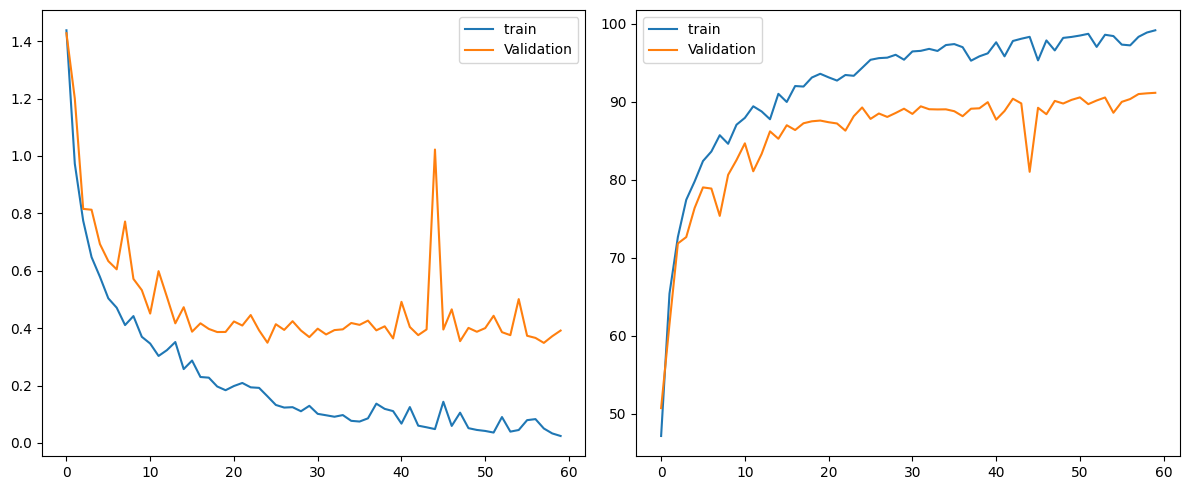

In [ ]:
# TODO: Plot Loss
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(np.arange(num_epochs), loss_dic['train'], label='train ')
axes[0].plot(np.arange(num_epochs), loss_dic['val'], label='Validation')
axes[0].legend()

# TODO: Plot Accuracy
axes[1].plot(np.arange(num_epochs), acc_dic['train'], label='train ')
axes[1].plot(np.arange(num_epochs), acc_dic['val'], label='Validation')
axes[1].legend()

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
# TODO: Run Model on Testset
model = ResNet18()
model.to(device)
model.load_state_dict(torch.load(model_path))
test_acc = test_loop(model, test_loader)

Testing: 100%|██████████| 79/79 [00:03<00:00, 21.36it/s, Acc=91.09%]


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

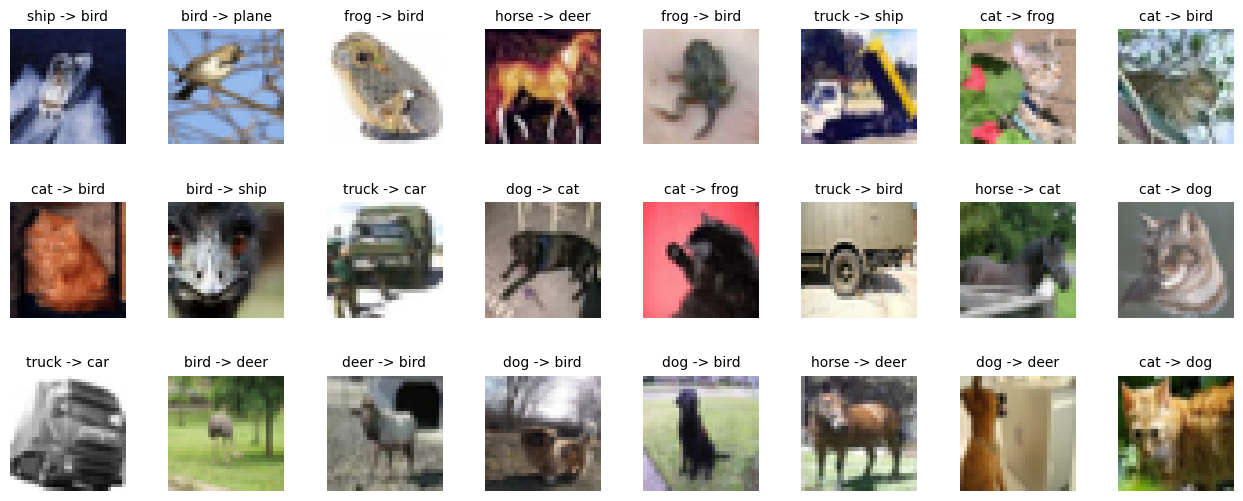

In [ ]:
# TODO: Plot Samples with Wrong Predicted Classes
all_images = []
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_images.extend(images.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

images = torch.tensor(np.array(all_images))
labels = torch.tensor(all_labels)
predicted = torch.tensor(all_preds)

wrong_indices = [i for i in range(len(images)) if labels[i].item() != predicted[i].item()]
correct_indices = [i for i in range(len(images)) if labels[i].item() == predicted[i].item()] # for next section

selected_indices = sample(wrong_indices, 24)
selected_images = [images[i] for i in selected_indices]
selected_labels = [labels[i].item() for i in selected_indices]
predicted_labels = [predicted[i].item() for i in selected_indices]

# Plot Images
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(16, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for i, ax in enumerate(axes.flat):
    img = selected_images[i]*std + mean
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format
    ax.imshow(img)

    # Format True -> Predicted label
    true_label = classes[selected_labels[i]]
    pred_label = classes[predicted_labels[i]]

    ax.set_title(f"{true_label} -> {pred_label}", fontsize=10, color='black')
    ax.axis("off")

plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
# TODO: Find Features and Put Them in One Dimensional List

all_train = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=1)
model.eval()

all_embeddings = []
for inputs, labels in all_train:
    inputs = inputs.to(device)
    embeddings = model.feature_space(inputs)
    embeddings = embeddings.detach().cpu().numpy()
    for embedding in embeddings:
        all_embeddings.append(embedding.tolist())

train_feature_space = torch.FloatTensor(all_embeddings)
print(train_feature_space.shape)

torch.Size([50000, 512])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** To find the nearest neighbors in the feature space, you can use any library of your choice.

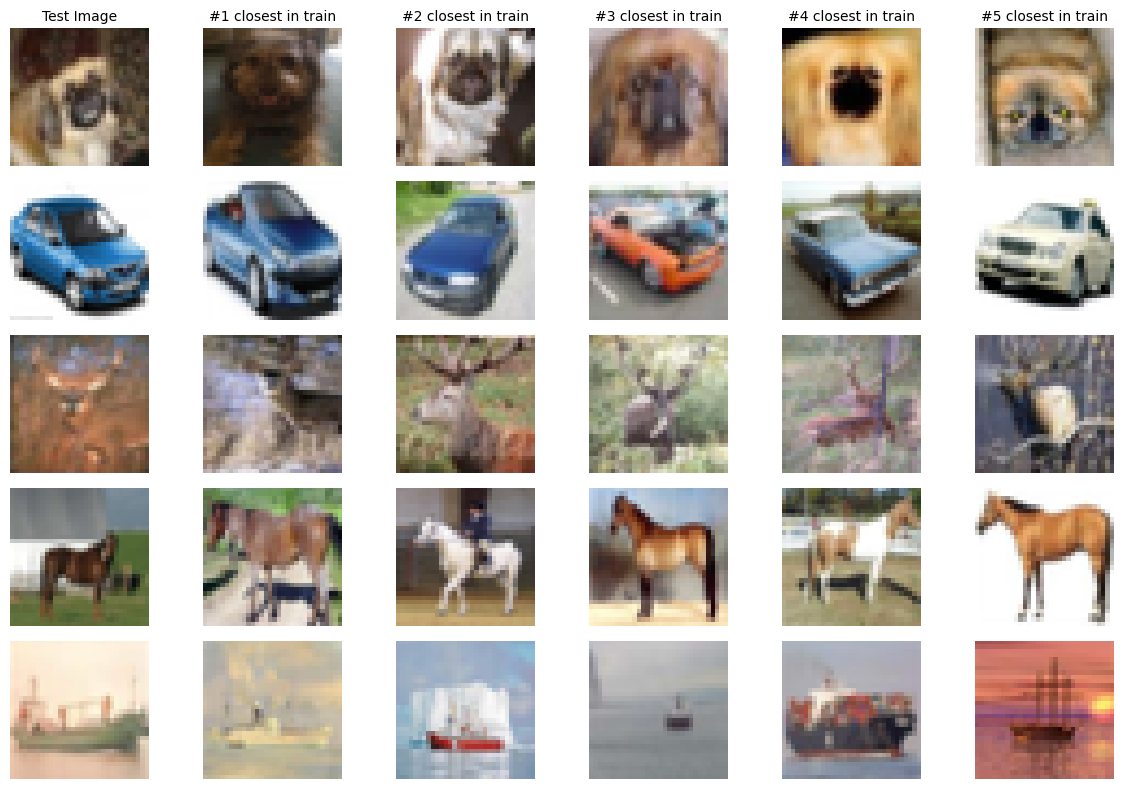

In [ ]:
# TODO: Find Features List for Test Samples
selected_indices = sample(correct_indices, 5)

test_embeddings = []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    embeddings = model.feature_space(inputs)
    embeddings = embeddings.detach().cpu().numpy()
    test_embeddings.extend(embeddings)

test_feature_space = torch.FloatTensor(test_embeddings)
selected_test_features = test_feature_space[selected_indices]

# Find K Nearest Features
def knn(feature, features, k=5):
    diff = features - feature
    norms = torch.linalg.norm(diff, dim=1)
    nearests = torch.topk(norms, k, largest=False)
    return nearests.indices

nearests_index = [knn(feature, train_feature_space) for feature in selected_test_features]

train_images = np.array(dataset.data)
selected_train_images = [[train_images[idx.item()] for idx in group] for group in nearests_index]

test_images = np.array(test_dataset.data)
test_images = [test_images[idx] for idx in selected_indices]

# Plot Features' Images
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 8))
cols = ['Test Image'] + [f'#{i} closest in train' for i in range(1, 6)]

for i in range(5):
    axes[i, 0].imshow(test_images[i].astype('uint8'))
    axes[i, 0].axis('off')

    for j in range(5):
        img = selected_train_images[i][j]
        axes[i, j+1].imshow(selected_train_images[i][j].astype('uint8'))
        axes[i, j+1].axis('off')

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.tight_layout()
plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
# TODO: Get Samples
indices = torch.tensor(sample(range(50000), 2000))
samples = train_feature_space[indices].to(device)
output = model.fc(samples)
_, pred = torch.max(output, 1)
pred = pred.cpu().numpy()

# TODO: Use TSNE
samples_embedded = TSNE(n_components=2).fit_transform(samples.cpu().numpy())
samples_embedded.shape

(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

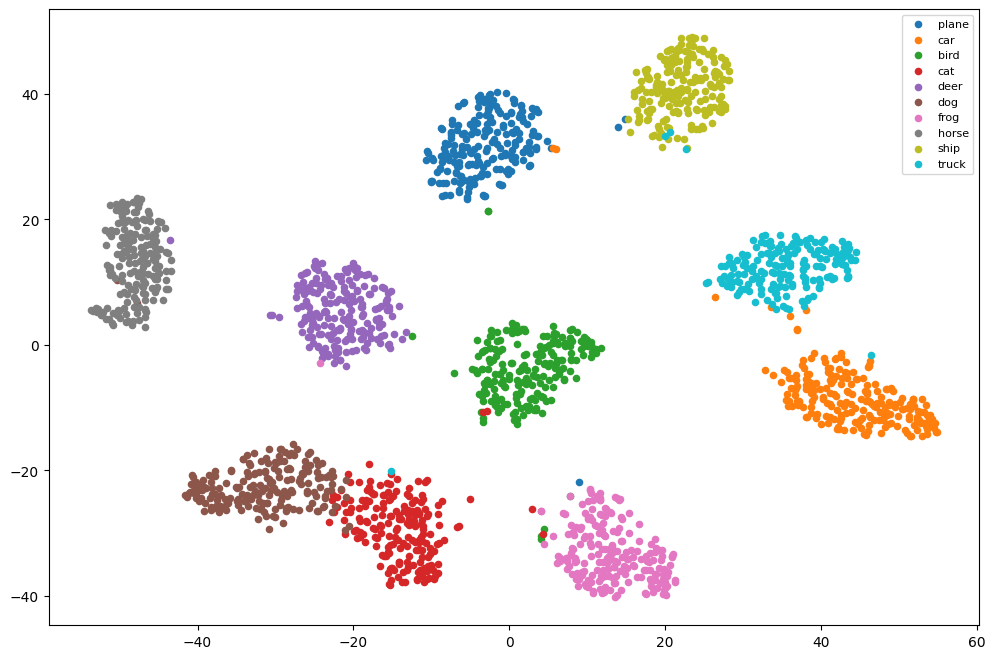

In [ ]:
# TODO: Plot Results
fig, ax = plt.subplots(figsize=(12, 8))
zipped = list(zip(samples_embedded, pred))

for i, label in enumerate(classes):
    data = np.array([x[0] for x in zipped if x[1] == i])
    ax.scatter(data[:,0], data[:, 1], s=20, label=label)

ax.legend(prop={'size': 8})
plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [ ]:
# TODO: Select an Image

random_index = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[random_index]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [ ]:
# TODO: Get Intermediate Output

clipped = nn.Sequential(*list(model.children())[:2])
intermediate_output = clipped(image.unsqueeze(0).to(device))

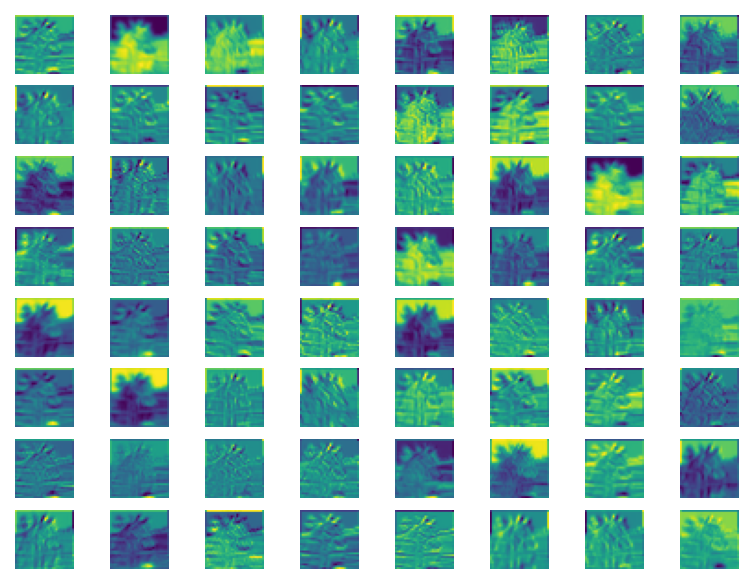

In [ ]:
def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

# TODO: Plot Intermediate Output
plot_intermediate_output(result=intermediate_output)

## CIFAR100

In this section, we aim to test the trained model on a different dataset. For this purpose, we will use the CIFAR100 dataset, which is similar to CIFAR10 but has different types and numbers of classes. In order for the model to perform well on the new dataset, we need to modify the last layer of the model. As you know from the previous section, the last layer of the model is a linear layer that maps the features to the number of classes. In this section, due to the increase in the number of classes, we plan to modify this layer and train the new linear layer with the new dataset. Note that all other layers and weights of the model will remain fixed and unchanged; only the last layer will be retrained.

### Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms.

In [ ]:
# TODO: Data Transforms

mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()
                                ])

test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),
                                ])

# TODO: Load Train Data
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# TODO: Split Train and Validation Data
train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])

# TODO: Load Test Data
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

# TODO: Define Data Loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:17<00:00, 9.51MB/s]


In [ ]:
classes = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee",
    "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee",
    "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
    "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse",
    "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum",
    "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train",
    "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]
print(len(classes))

100


### Visualization

Visualize 1 random images from each class.

- **Hint**:  You can use `plt.subplots` for visualization

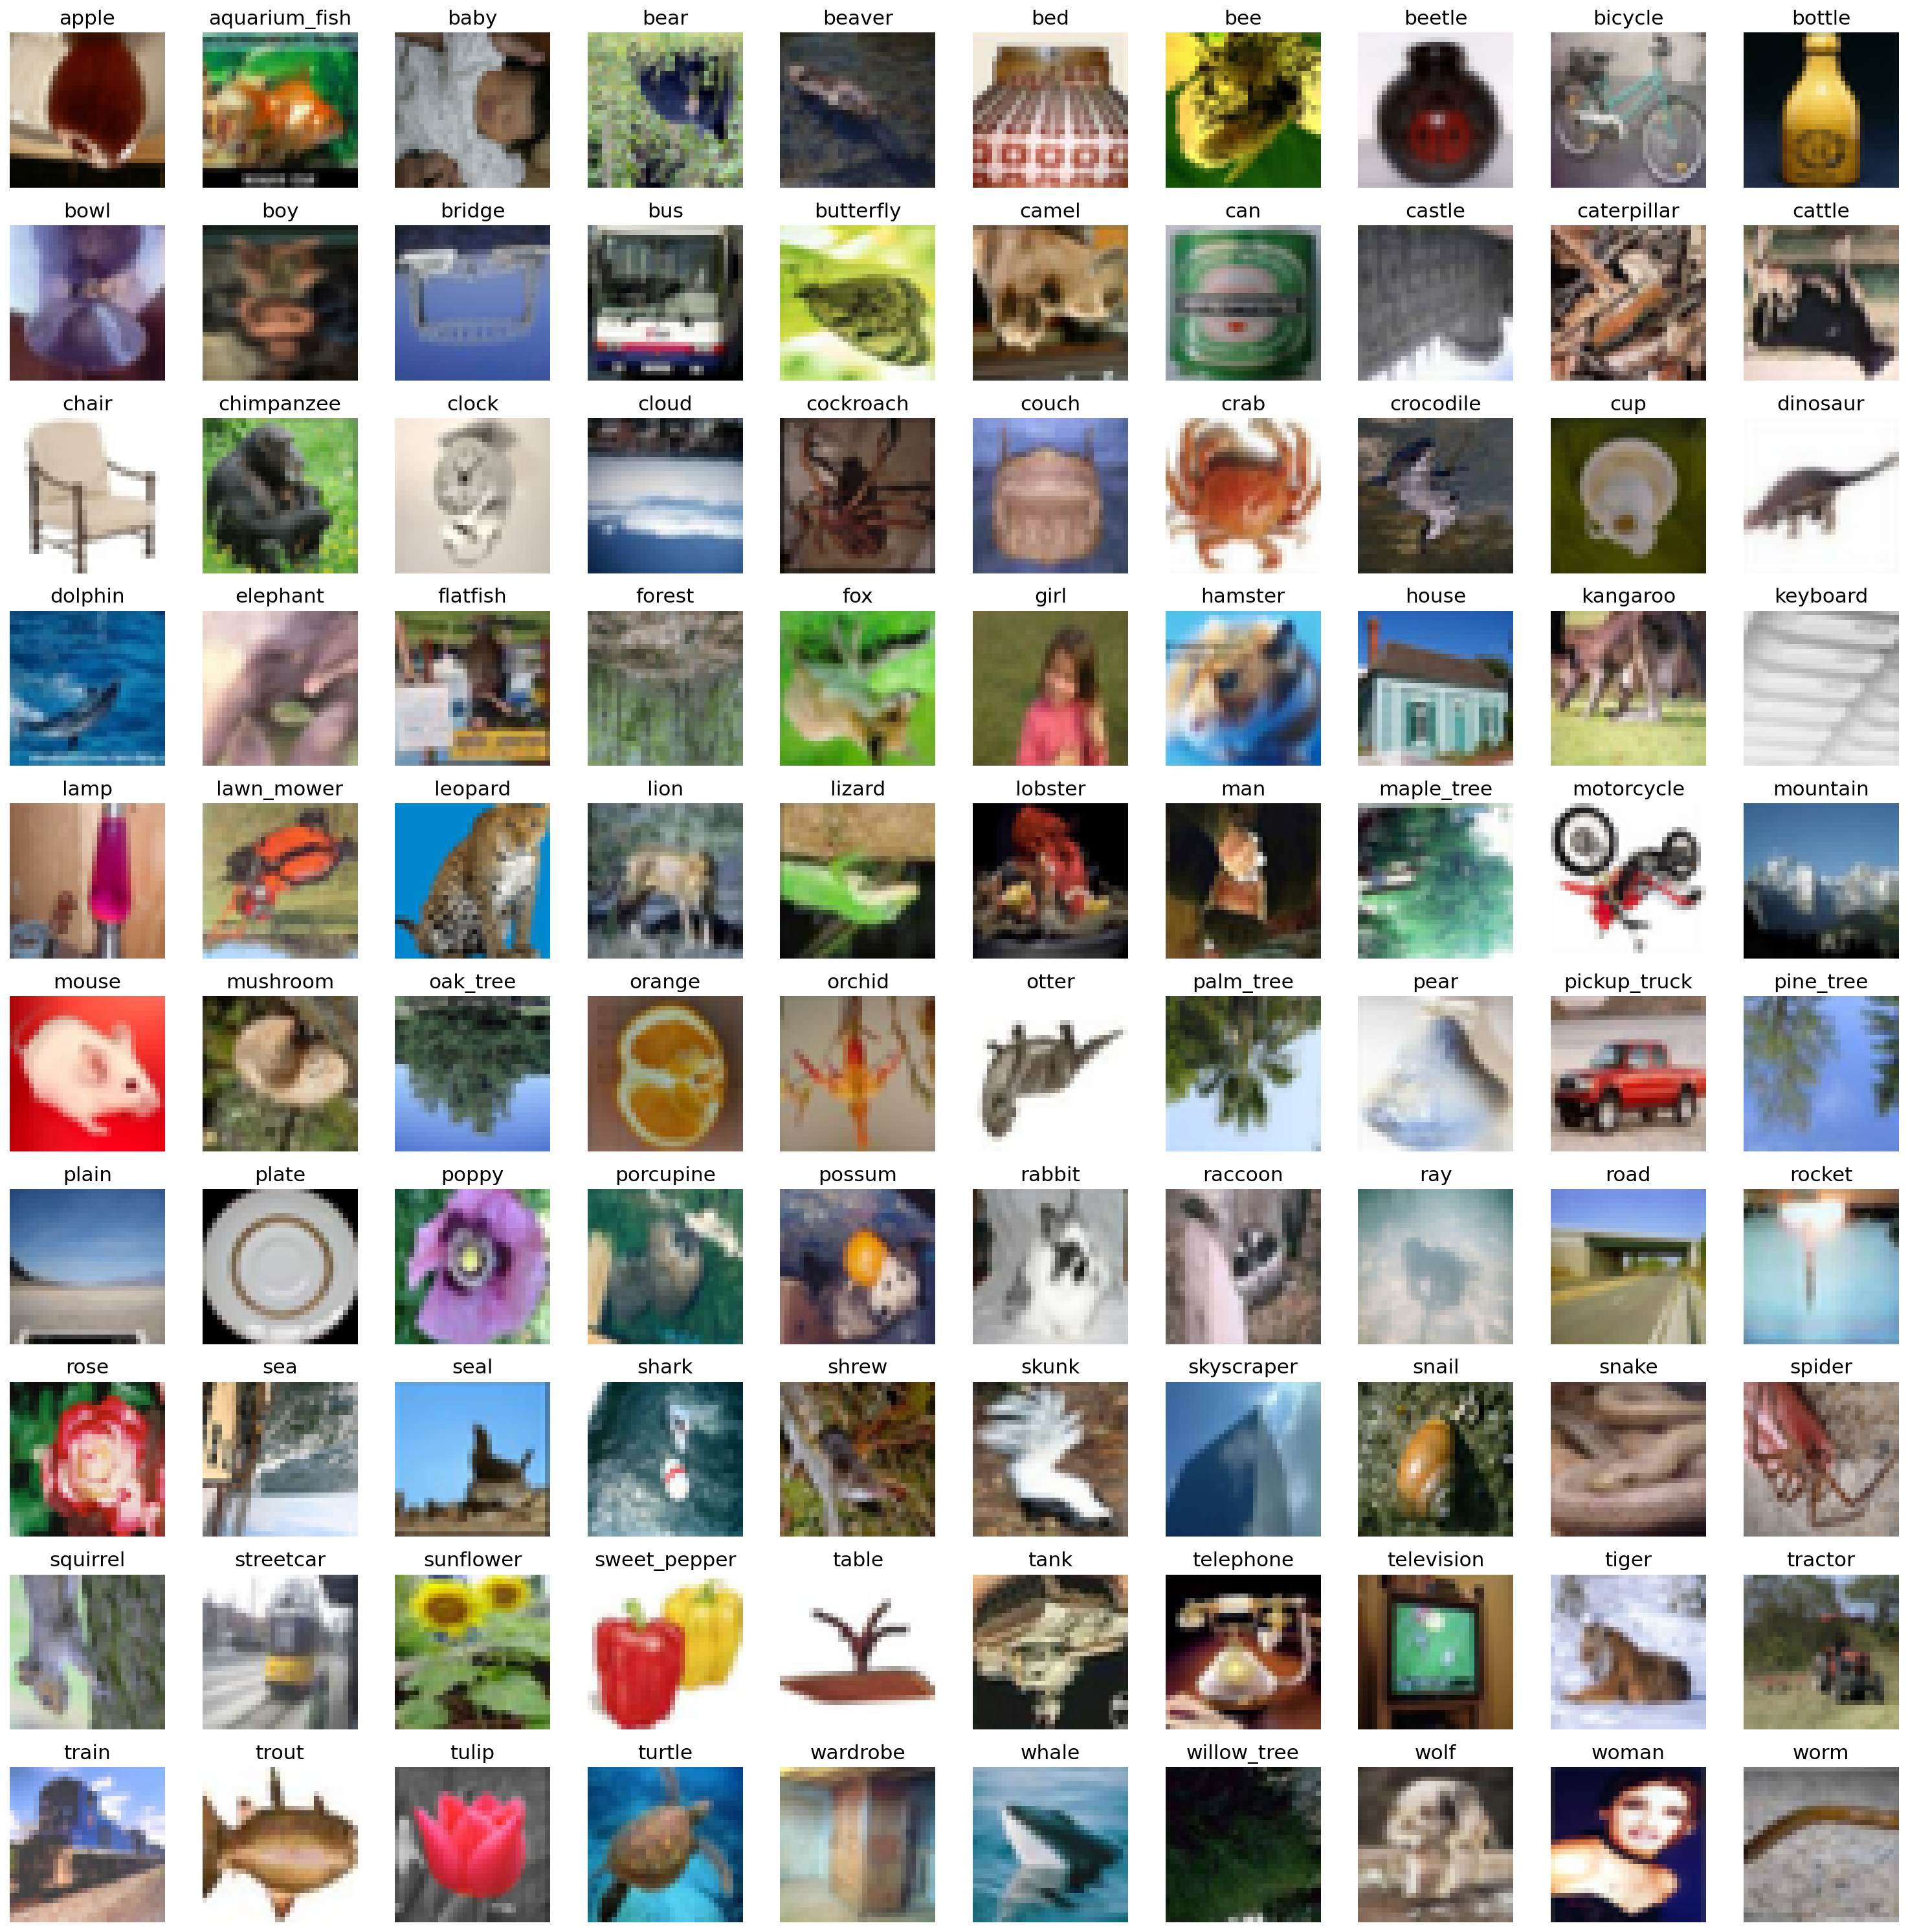

In [ ]:
# TODO: Find one Images from Each Class

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
images, labels = next(iter(data_loader))

num_images_per_class = 1
selected_images = {cls: [] for cls in range(100)}

# Find one image from each class
for cls in range(100):
    class_indices = np.where(labels.numpy() == cls)[0]
    selected_indices = sample(list(class_indices), num_images_per_class)
    selected_images[cls] = [images[i] for i in selected_indices]

# Plot Images
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()

for idx, (cls, imgs) in enumerate(selected_images.items()):
    img = imgs[0]
    img = img * std + mean
    img = img.numpy().transpose(1, 2, 0)

    ax = axes[idx]
    ax.imshow(img)
    ax.set_title(dataset.classes[cls], fontsize=15)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Modify Model

Change the final linear layer of the model according to the new number of classes And freeze all other layers.
- Do not forgot to move model to `device`

In [ ]:
# Load Pretrained Model
model = ResNet18()
model.load_state_dict(torch.load(model_path))

# Freeze All Layers
for param in model.parameters():
    param.requires_grad = False

# Modify The Last Linear Layer
model.fc = nn.Linear(512, 100)

# Move Model to Device
model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (identity): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
# TODO: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

### Train

Train the Model (Only Last Layer)

In [ ]:
# TODO: Train The Model
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc= train_loop(model, train_loader, criterion, optimizer, scheduler)

Epoch 30/30: 100%|██████████| 333/333 [00:15<00:00, 21.18it/s, Loss=1.870e+00, Acc=41.06%]


### Test

Evaluate the Model on CIFAR-100 Test Set. 40% accuracy is sufficient.


In [ ]:
# TODO: Evaluate Model on CIFAR100
test_loss, test_acc= val_loop(model, test_loader, criterion)

# TODO: Print Accuracy
print(f'\nTest Accuracy on CIFAR-100: {test_acc}%')

Validating: 100%|██████████| 79/79 [00:03<00:00, 21.21it/s, Loss=2.340e+00, Acc=40.11%]


Test Accuracy on CIFAR-100: 40.11%


### Question
You might think that 40% accuracy is quite low. However, first of all, consider that the classification is done over 100 classes. The accuracy of a random model in this case is 1%. Also, we only changed one linear layer of the model, and the rest of the weights remained unchanged. What do you think is the reason the model can achieve a reasonably good generalization ability on a completely new dataset with just the change of one linear layer at the end?

Answer:
*The model achieves good generalization with only the last layer trained because the pretrained ResNet18 already learned rich, transferable features from a similar dataset (like CIFAR10). These features capture general patterns (edges, textures, shapes) that are useful across many tasks. So, by just training the final linear layer, we adapt these features to the new dataset.*

### Visualize incorrectly predicted samples from testset

Visualize *10* random images from testset that are incorrectly predicted by the model

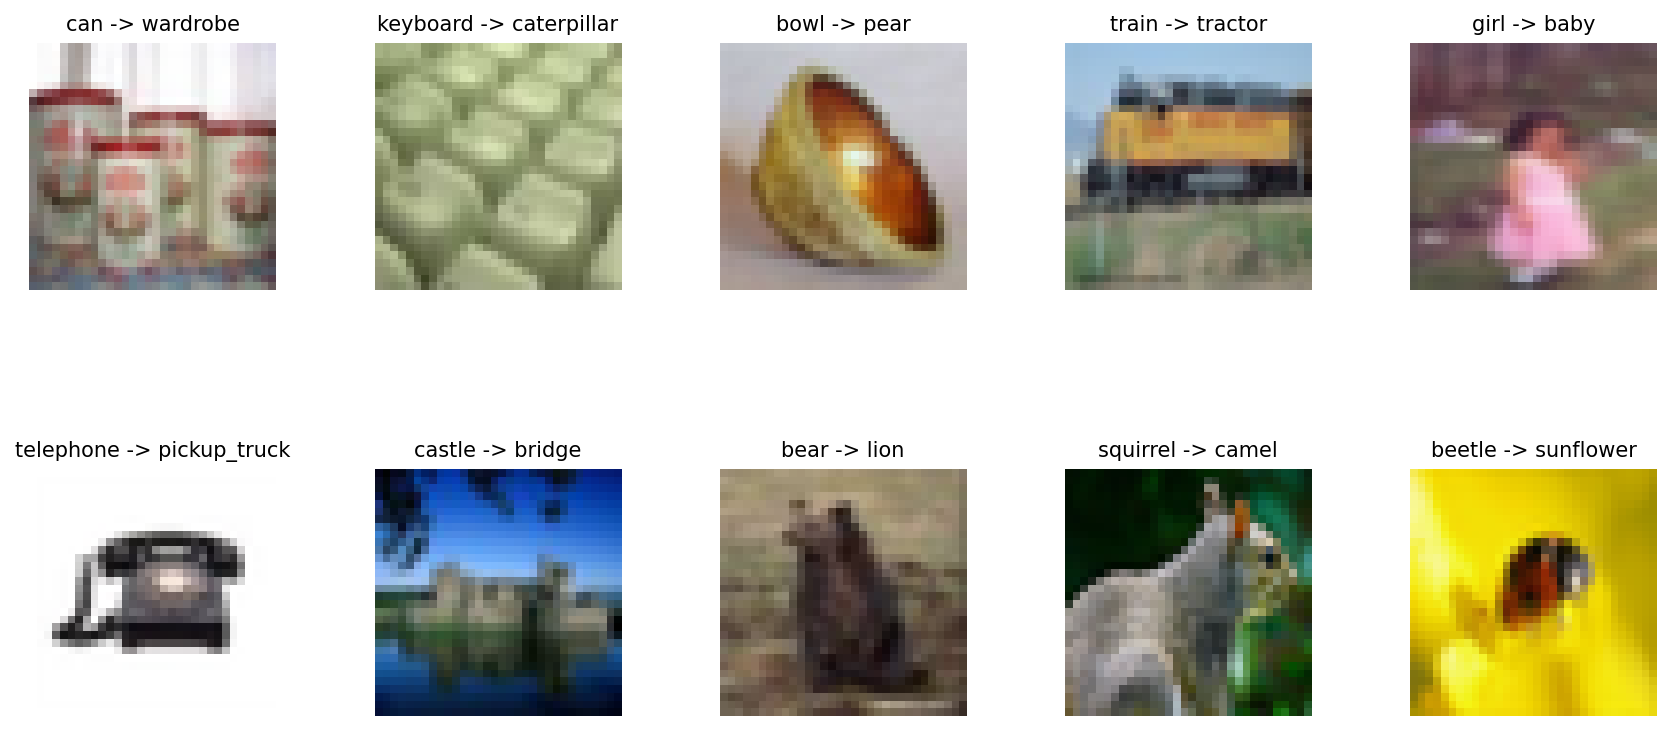

In [ ]:
# TODO: Plot Samples with Wrong Predicted Classes

all_images = []
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_images.extend(images.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

images = np.array(all_images)
labels = np.array(all_labels)
predicted = np.array(all_preds)

wrong_indices = [i for i in range(len(images)) if labels[i].item() != predicted[i].item()]
selected_indices = sample(wrong_indices, 10)
selected_images = [images[i] for i in selected_indices]
selected_labels = [labels[i].item() for i in selected_indices]
predicted_labels = [predicted[i].item() for i in selected_indices]

# Plot Images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 6))
fig.subplots_adjust(hspace=0.6, wspace=0.4)
axes = axes.flatten()

for i, ax in enumerate(axes.flat):
    img = selected_images[i]*np.array(std) + np.array(mean)
    img = img.transpose(1, 2, 0)
    ax.imshow(img)

    # Format True -> Predicted label
    true_label = classes[selected_labels[i]]
    pred_label = classes[predicted_labels[i]]

    ax.set_title(f"{true_label} -> {pred_label}", fontsize=10, color='black')
    ax.axis("off")

plt.show()

### Plot accuracy for each class

Plot accuracy of model on testset for each class.

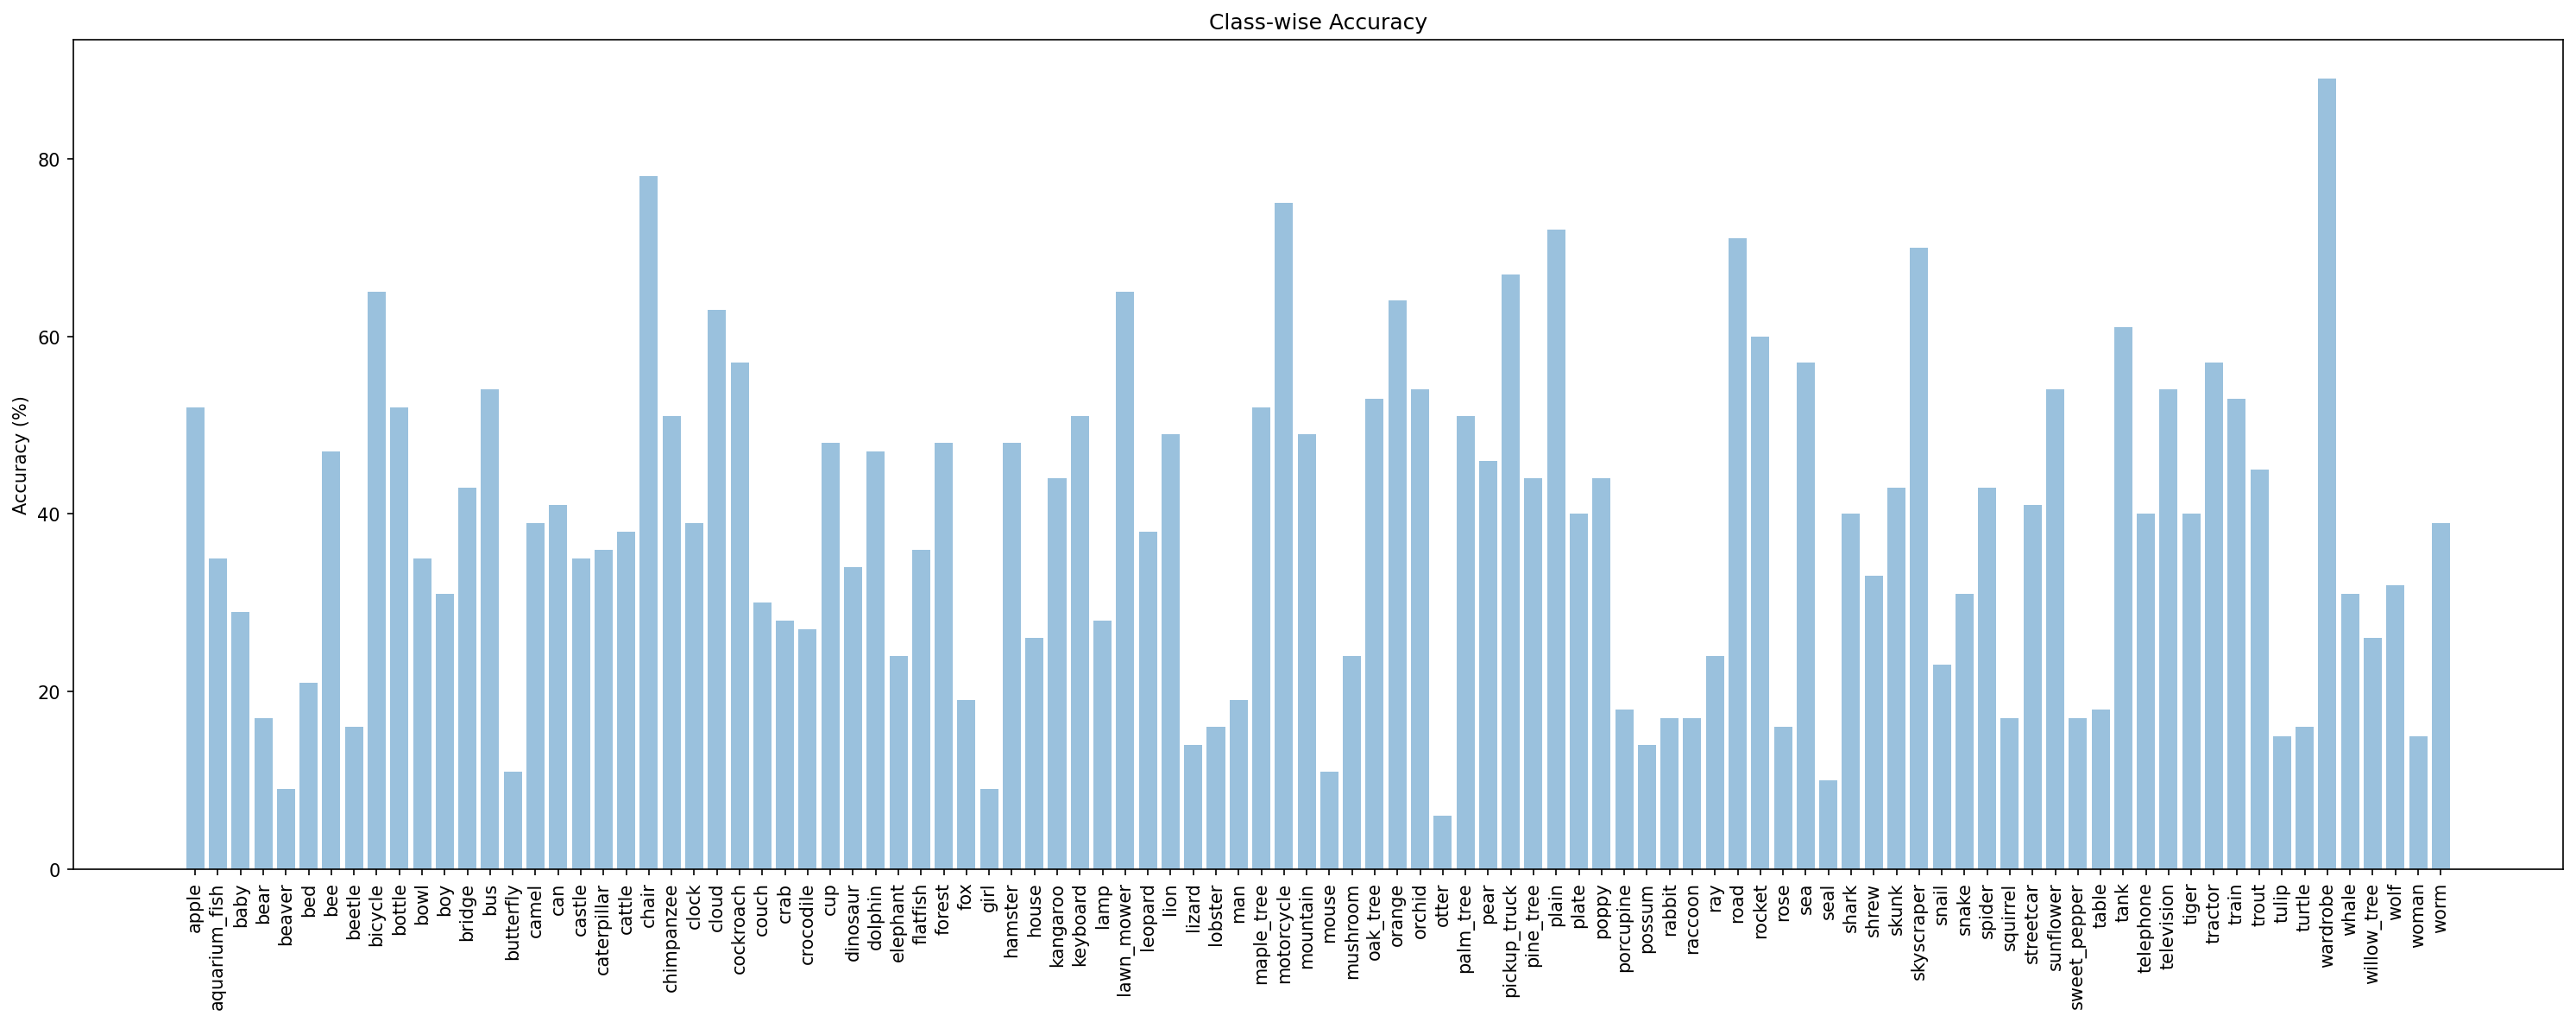

In [ ]:
# TODO: Calculate Accuracy for Each Class
class_correct = [0] * 100
class_total = [0] * 100

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for label, pred in zip(labels, preds):
            class_total[label.item()] += 1
            if label == pred:
                class_correct[label.item()] += 1

class_accuracy = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# TODO: Plot Class-Wise Accuracy
plt.figure(figsize=(20, 8))
plt.bar(range(100), class_accuracy, alpha=0.45)
plt.xticks(ticks=range(100), labels=classes, rotation=90)
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.tight_layout()
plt.show()

### The classes with the best and worst accuracy

Based on the results from the previous section, obtain the 5 classes with the best accuracy and the 5 classes with the worst accuracy on the testset, and display one sample from each of them.

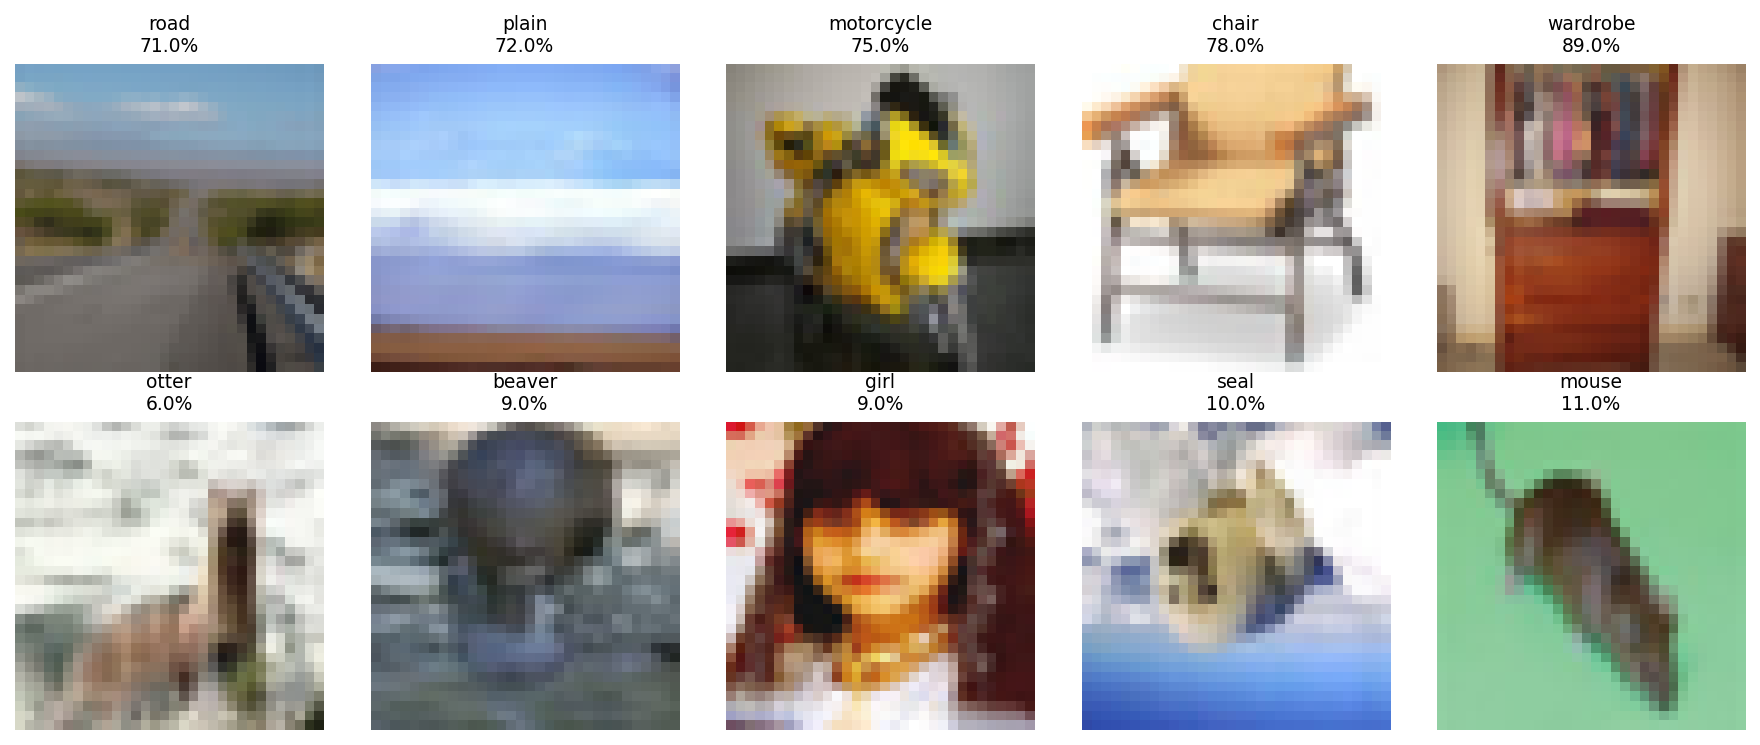

In [ ]:
# TODO: Find Top 5 Best and Worst Performing Classes
sorted_indices = np.argsort(class_accuracy)
worst_indices = sorted_indices[:5]
best_indices = sorted_indices[-5:]

# Plot a Sample Image From Each of The Best and Worst Performing Classes
def get_sample_image_for_class(target_class, dataset):
    for img, label in dataset:
        if label == target_class:
            return img
    return None

selected_indices = best_indices.tolist() + worst_indices.tolist()
selected_labels = [dataset.classes[i] for i in selected_indices]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, class_idx in enumerate(selected_indices):
    img = get_sample_image_for_class(class_idx, dataset)
    img = img * std + mean  # unnormalize if needed
    img = img.numpy().transpose(1, 2, 0)

    axes[i].imshow(img)
    axes[i].set_title(f"{dataset.classes[class_idx]}\n{class_accuracy[class_idx]:.1f}%", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Question
What do you think is the reason for the significant accuracy difference between different classes? What differences do you observe between the classes with the best and worst accuracy? Can you provide an analysis of the results and relate them to the model’s feature space?

Answer:

**Analysis of Best vs Worst Classes**

✅ Best Performing Classes (e.g., wardrobe, chair, motorcycle):
- Distinctive shapes and textures: These classes have consistent, rigid, and well-defined structures that are easier for CNNs to recognize (e.g., straight lines, corners, and fixed color regions).
- Low intra-class variability: Items like wardrobes or motorcycles generally look similar across samples.
- Clear backgrounds: Backgrounds are less cluttered, making objects stand out more.

❌ Worst Performing Classes (e.g., otter, beaver, girl, seal):
- High intra-class variability: Animals or humans can appear in many poses, lighting conditions, and environments, making it harder for the model to generalize.
-Background complexity: These images often contain natural scenes (water, snow, foliage) which can distract the model.
- Fine-grained differences: These classes are visually similar to others (e.g., otter vs beaver vs seal), and may be confused easily.

----
**Relation to Model’s Feature Space**

The model is using high-level features from a frozen backbone. That means:

- It benefits from generic object-level features (edges, corners, textures).

- It struggles with fine-grained discrimination, which requires deeper adaptation.

- Semantic gaps between some class clusters can result in unbalanced performance, as some class groups are better aligned with pretrained features.



[Reference](https://github.com/deepmancer/resnet-cifar-classification/tree/master)